In [53]:
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import os   # <-- NEW: for random 32-byte z in secret key

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
np.set_printoptions(linewidth=200)

# Ring parameters
N = 256
q = 12289

BOUND_S = 3
BOUND_E = 2


In [54]:
def mod_q(x):
    """Reduce array or scalar x modulo q into [0, q-1]."""
    return np.mod(x, q)

def sample_small_vec(size, bound):
    """Vector with entries in [-bound, ..., bound]."""
    return np.random.randint(-bound, bound + 1, size=size)

def sample_small_scalar(bound):
    """Scalar in [-bound, ..., bound]."""
    return int(np.random.randint(-bound, bound + 1))

def circular_distance(a, b, q):
    """Circular distance on Z_q between a and b."""
    return min((a - b) % q, (b - a) % q)

def serialize_pk(pk):
    """
    Serialize public key (a, b) to bytes for hashing.
    """
    a, b = pk
    return a.tobytes() + b.tobytes()

def sample_small_poly_from_seed(seed_bytes, bound, size=N):
    """
    Deterministically sample a small polynomial using a seed.
    Not crypto-strong, but fine for this prototype.
    """
    # turn first 4 bytes into an integer seed for RNG
    seed_int = int.from_bytes(seed_bytes[:4], 'big')
    rng = np.random.RandomState(seed_int)
    return rng.randint(-bound, bound + 1, size=size)



In [33]:
def make_base_poly(N, q):
    """
    Define a 'wave-like' base polynomial a(x) using a sum of sines.
    This is your WSIDH 'wave' object, interpreted as coefficients in Z_q.
    """
    k = np.arange(N)
    f = (
        400 * np.sin(2 * np.pi * k / N) +
        250 * np.sin(4 * np.pi * k / N) +
        150 * np.sin(6 * np.pi * k / N)
    )
    return mod_q(np.rint(f).astype(int))

# Build the global base polynomial a(x) (public parameter)
a = make_base_poly(N, q)


In [68]:
def poly_mul(p, q_poly):
    """
    Fast polynomial multiplication using FFT (conceptually like NTT).

    We work in Z_q[x]/(x^N - 1) here, meaning cyclic convolution
    of length N. For our RLWE-style WSIDH prototype, this is fine
    and much faster than the naive O(N^2) convolution.
    """

    # FFT of inputs
    fa = np.fft.fft(p)
    fb = np.fft.fft(q_poly)

    # Pointwise multiply
    fc = fa * fb

    # Inverse FFT
    c_complex = np.fft.ifft(fc)

    # Remove tiny imaginary parts safely
    c_real = np.real_if_close(c_complex, tol=1e5)

    # Round to nearest integer
    c_int = np.rint(c_real).astype(int)

    # Reduce mod q
    return mod_q(c_int)

# Plot helper
def plot_poly(poly, title):
    plt.figure(figsize=(12, 4))
    plt.plot(poly, linewidth=1)
    plt.title(title)
    plt.xlabel("Coefficient index")
    plt.ylabel("Value (mod q)")
    plt.show()


In [36]:
def sample_small_poly():
    """Small polynomial with coefficients in [-BOUND_S, ..., BOUND_S]."""
    return sample_small_vec(N, BOUND_S)

def sample_noise_poly():
    """Noise polynomial with coefficients in [-BOUND_E, ..., BOUND_E]."""
    return sample_small_vec(N, BOUND_E)


In [55]:
def poly_keygen():
    """
    CCA-ready KeyGen for poly-WSIDH (RLWE-style).

    Public key:
        pk = (a, b), where b = a*s + e

    Secret key:
        sk = (s, z, pk) where
            s = small secret polynomial
            z = random 32-byte fallback secret
            pk = public key (needed for CCA re-encryption)
    """
    global a

    s = sample_small_poly()      # secret
    e = sample_noise_poly()      # keygen noise

    b = mod_q(poly_mul(a, s) + e)

    pk = (a, b)
    z = os.urandom(32)           # extra secret for CCA fallback

    sk = (s, z, pk)
    return pk, sk

# regenerate keypair
pk, sk = poly_keygen()


In [57]:
def poly_encaps(pk):
    """
    CCA-style Encaps:
      - choose random 1-byte m
      - derive coins = H(m || pk)
      - deterministically derive r, e1, e2 from coins
      - build ct = (u, v)
      - derive K_enc = SHA3-256(m || u || v)
    """
    a, b = pk

    # 1-byte message (we still only encode its lowest bit)
    m = int.from_bytes(os.urandom(1), 'big')  # 0..255
    m_bit = m & 1                             # use 0/1 for encoding

    # Coins = H(m || pk)
    pk_bytes = serialize_pk(pk)
    coins = hashlib.sha3_256(m.to_bytes(1, 'big') + pk_bytes).digest()

    # Derive seeds for r, e1, e2 from coins
    seed_r  = hashlib.sha3_256(coins + b"r").digest()
    seed_e1 = hashlib.sha3_256(coins + b"e1").digest()
    seed_e2 = hashlib.sha3_256(coins + b"e2").digest()

    # Deterministic small polys
    r  = sample_small_poly_from_seed(seed_r,  BOUND_S)
    e1 = sample_small_poly_from_seed(seed_e1, BOUND_E)
    e2 = sample_small_poly_from_seed(seed_e2, BOUND_E)

    # u = a*r + e1
    u = mod_q(poly_mul(a, r) + e1)

    # v_no_msg = b*r + e2
    v_no_msg = mod_q(poly_mul(b, r) + e2)

    # encode 1 bit of m
    encode_0 = 0
    encode_1 = q // 2
    m_enc = encode_1 if m_bit == 1 else encode_0
    m_poly = np.full(N, m_enc, dtype=int)

    v = mod_q(v_no_msg + m_poly)

    # KEM key: K_enc = H(m || u || v)
    byte_m = m.to_bytes(1, 'big')
    byte_u = u.tobytes()
    byte_v = v.tobytes()
    K_enc = hashlib.sha3_256(byte_m + byte_u + byte_v).digest()

    ct = (u, v)
    return ct, K_enc


In [58]:
def poly_decaps(ct, sk):
    """
    CCA-secure Decaps for WSIDH.

    - Use s to decode a bit m_bit_dec from ct.
    - Try all 256 possible m values that match that bit (0..255 with same LSB),
      and re-encrypt deterministically from each candidate m.
      (Tiny brute force, since 256 is nothing.)
    - If we find an m such that ct_recomputed == ct_received:
          use K_dec = H(m || u || v)
      otherwise:
          use K_dec = H(z || u || v)
    """
    u, v = ct
    s, z, pk = sk
    a, b = pk

    # Step 1: decode bit m_bit_dec from diff = v - u*s
    us = poly_mul(u, s)
    diff = mod_q(v - us)

    encode_0 = 0
    encode_1 = q // 2

    vote_one = 0
    for x in diff:
        d0 = circular_distance(x, encode_0, q)
        d1 = circular_distance(x, encode_1, q)
        if d1 < d0:
            vote_one += 1

    m_bit_dec = 1 if vote_one > N // 2 else 0

    # Step 2: re-encrypt with all m that match this bit, look for a match
    pk_bytes = serialize_pk(pk)
    m_found = None
    u_bytes = u.tobytes()
    v_bytes = v.tobytes()

    for m_candidate in range(0, 256):
        if (m_candidate & 1) != m_bit_dec:
            continue  # skip if bit doesn't match

        # coins = H(m_candidate || pk)
        coins = hashlib.sha3_256(m_candidate.to_bytes(1, 'big') + pk_bytes).digest()
        seed_r  = hashlib.sha3_256(coins + b"r").digest()
        seed_e1 = hashlib.sha3_256(coins + b"e1").digest()
        seed_e2 = hashlib.sha3_256(coins + b"e2").digest()

        r_re  = sample_small_poly_from_seed(seed_r,  BOUND_S)
        e1_re = sample_small_poly_from_seed(seed_e1, BOUND_E)
        e2_re = sample_small_poly_from_seed(seed_e2, BOUND_E)

        u_re = mod_q(poly_mul(a, r_re) + e1_re)
        v_no_msg_re = mod_q(poly_mul(b, r_re) + e2_re)

        # encode bit from m_candidate
        bit_cand = m_candidate & 1
        m_enc_cand = encode_1 if bit_cand == 1 else encode_0
        m_poly_cand = np.full(N, m_enc_cand, dtype=int)

        v_re = mod_q(v_no_msg_re + m_poly_cand)

        # Compare recomputed ct with received ct
        if np.array_equal(u_re, u) and np.array_equal(v_re, v):
            m_found = m_candidate
            break

    if m_found is not None:
        # Valid ciphertext: real key
        byte_m = m_found.to_bytes(1, 'big')
        K_dec = hashlib.sha3_256(byte_m + u_bytes + v_bytes).digest()
    else:
        # Invalid/tampered ciphertext: fallback key using secret z
        K_dec = hashlib.sha3_256(z + u_bytes + v_bytes).digest()

    return K_dec


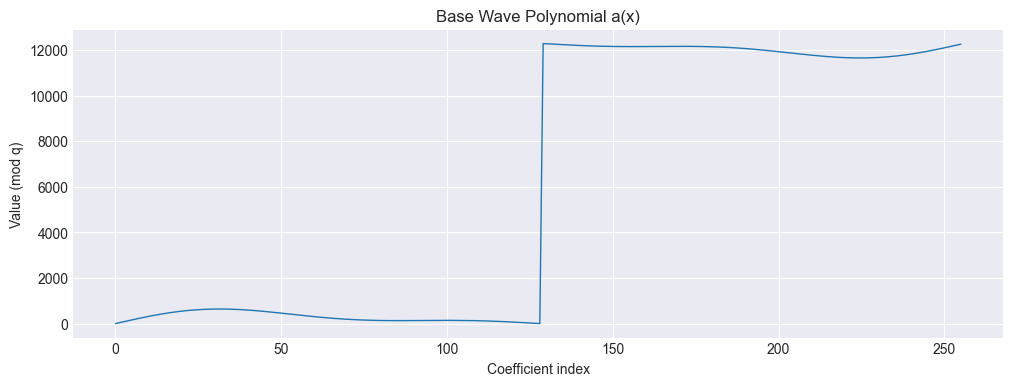

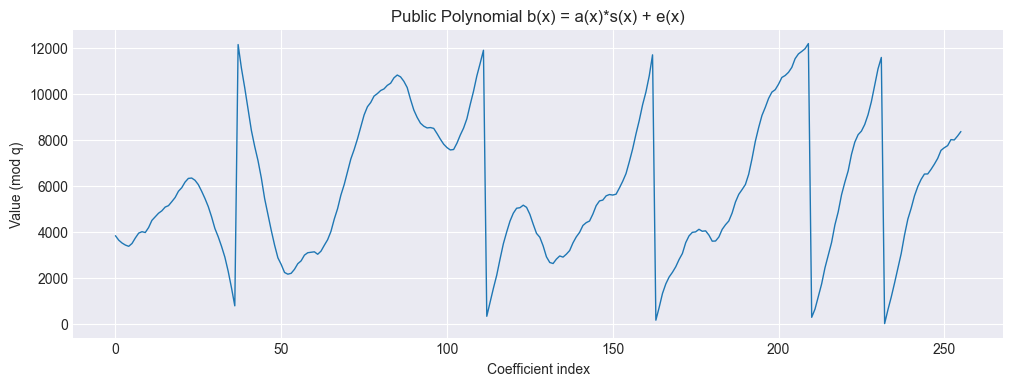

/var/folders/z9/zgqy58j14cs6830tcjx6bqsc0000gn/T/ipykernel_8106/3185497601.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.rint(np.fft.ifft(fc)).astype(int)


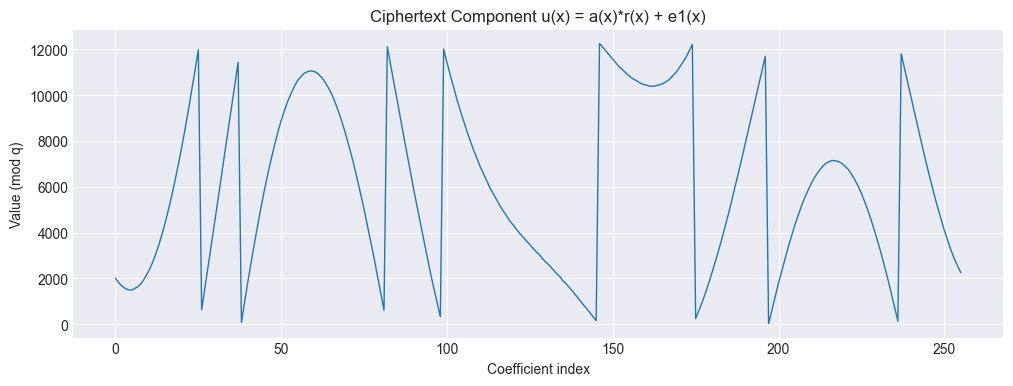

In [66]:
# Plot base wave a(x)
plot_poly(a, "Base Wave Polynomial a(x)")

# Plot corresponding b(x)
_, b = pk
plot_poly(b, "Public Polynomial b(x) = a(x)*s(x) + e(x)")

# Example ciphertext and its u component
ct_example, K_example = poly_encaps(pk)
u_example, v_example = ct_example
plot_poly(u_example, "Ciphertext Component u(x) = a(x)*r(x) + e1(x)")


/var/folders/z9/zgqy58j14cs6830tcjx6bqsc0000gn/T/ipykernel_8106/3185497601.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.rint(np.fft.ifft(fc)).astype(int)


Decryption success rate: 1.0


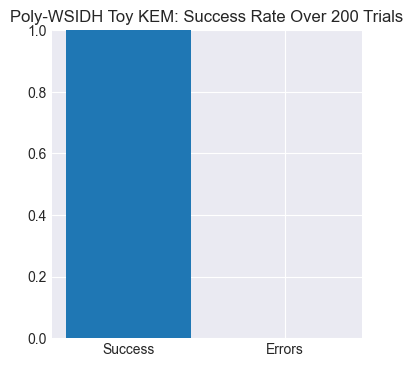

In [67]:
def poly_experiment(trials=200, verbose=False):
    """
    Run 'trials' random encaps/decaps attempts and
    return the success rate.
    """
    pk, sk = poly_keygen()
    success = 0
    for i in range(trials):
        ct, K_enc = poly_encaps(pk)
        K_dec = poly_decaps(ct, sk)
        if K_enc == K_dec:
            success += 1
        if verbose:
            print(f"Trial {i}: K_enc={K_enc}, K_dec={K_dec}")
    return success / trials

success_rate = poly_experiment(trials=200, verbose=False)
print("Decryption success rate:", success_rate)

plt.figure(figsize=(4,4))
plt.bar(["Success", "Errors"], [success_rate, 1-success_rate])
plt.ylim(0, 1)
plt.title("Poly-WSIDH Toy KEM: Success Rate Over 200 Trials")
plt.show()


BOUND_E=0: success=1.000
BOUND_E=1: success=1.000
BOUND_E=2: success=1.000
BOUND_E=3: success=1.000


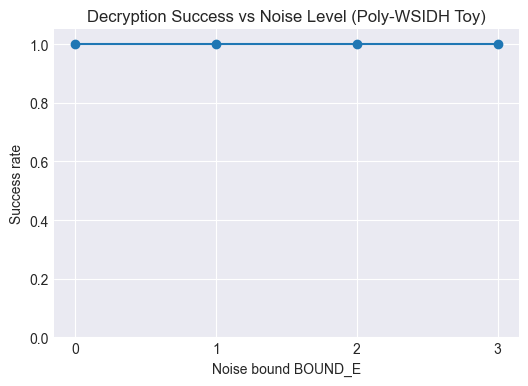

In [63]:
def sweep_noise(bounds, trials=200):
    rates = []
    for be in bounds:
        global BOUND_E
        BOUND_E = be
        rate = poly_experiment(trials=trials, verbose=False)
        rates.append(rate)
        print(f"BOUND_E={be}: success={rate:.3f}")
    return bounds, rates

bounds = [0, 1, 2, 3]
xs, ys = sweep_noise(bounds, trials=200)

plt.figure(figsize=(6,4))
plt.plot(xs, ys, marker="o")
plt.xticks(xs)
plt.ylim(0, 1.05)
plt.xlabel("Noise bound BOUND_E")
plt.ylabel("Success rate")
plt.title("Decryption Success vs Noise Level (Poly-WSIDH Toy)")
plt.show()
